# Install finrl package

In [ ]:
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git --quiet

# Import packages

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.use('Agg')
import datetime
import os
from finrl import config
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer
from finrl.meta.preprocessor.preprocessors import data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot
from stable_baselines3.common.logger import configure
import sys
import itertools
sys.path.append("../FinRL-Library")


In [21]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

# Download **Apple stocks data** from Yahoo Finance api

In [2]:
data_df = YahooDownloader(start_date = '2009-01-01',
                          end_date = '2021-01-01',
                          ticker_list = ['AAPL']).fetch_data()
data_df.head()

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3021, 8)


,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.767330,746015200,AAPL,4
1,2009-01-05,3.327500,3.435000,3.311071,2.884122,1181608400,AAPL,0
2,2009-01-06,3.426786,3.470357,3.299643,2.836552,1289310400,AAPL,1
3,2009-01-07,3.278929,3.303571,3.223571,2.775258,753048800,AAPL,2
4,2009-01-08,3.229643,3.326786,3.215714,2.826793,673500800,AAPL,3


# Preprocessing

In [3]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(data_df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3020, 8)
Successfully added vix
Successfully added turbulence index


In [5]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)
processed_full.sort_values(['date','tic'],ignore_index=True).head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.767330,7.460152e+08,4.0,0.000000,2.990894,2.660558,100.000000,66.666667,100.000000,2.767330,2.767330,39.189999,0.0
1,2009-01-05,AAPL,3.327500,3.435000,3.311071,2.884122,1.181608e+09,0.0,0.002620,2.990894,2.660558,100.000000,66.666667,100.000000,2.825726,2.825726,39.080002,0.0
2,2009-01-06,AAPL,3.426786,3.470357,3.299643,2.836552,1.289310e+09,1.0,0.001864,2.946793,2.711876,70.355441,46.823477,100.000000,2.829335,2.829335,38.560001,0.0
3,2009-01-07,AAPL,3.278929,3.303571,3.223571,2.775258,7.530488e+08,2.0,-0.000739,2.925915,2.705716,50.429096,-29.722544,43.607834,2.815816,2.815816,43.389999,0.0
4,2009-01-08,AAPL,3.229643,3.326786,3.215714,2.826793,6.735008e+08,3.0,-0.000087,2.913864,2.722158,60.226933,-9.063144,48.357918,2.818011,2.818011,42.560001,0.0


# Trading Environment Building
This environment is based on OpenAI Gym framework, which simulates hte live stock market data with real market data. Let’s split the dataset into train(2009-01-01 to 2018-12-31) and trade(2019-01-01 to 2020-09-30) datasets.

## Splitting data

In [6]:
train = data_split(processed_full, start = '2009-01-01', end = '2019-01-01')
trade = data_split(processed_full, start = '2019-01-01', end = '2021-01-01')

## Initiate environment

In [7]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

Stock Dimension: 1, State Space: 11


In [8]:
train.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.767330,7.460152e+08,4.0,0.000000,2.990894,2.660558,100.000000,66.666667,100.000000,2.767330,2.767330,39.189999,0.0
1,2009-01-05,AAPL,3.327500,3.435000,3.311071,2.884122,1.181608e+09,0.0,0.002620,2.990894,2.660558,100.000000,66.666667,100.000000,2.825726,2.825726,39.080002,0.0
2,2009-01-06,AAPL,3.426786,3.470357,3.299643,2.836552,1.289310e+09,1.0,0.001864,2.946793,2.711876,70.355441,46.823477,100.000000,2.829335,2.829335,38.560001,0.0
3,2009-01-07,AAPL,3.278929,3.303571,3.223571,2.775258,7.530488e+08,2.0,-0.000739,2.925915,2.705716,50.429096,-29.722544,43.607834,2.815816,2.815816,43.389999,0.0
4,2009-01-08,AAPL,3.229643,3.326786,3.215714,2.826793,6.735008e+08,3.0,-0.000087,2.913864,2.722158,60.226933,-9.063144,48.357918,2.818011,2.818011,42.560001,0.0


In [10]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Implement DRL Algorithms
FinRL library uses fine-tuned algorithms such as  DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C, and TD3. The implementation of DRL algorithms are based on OpenAI and Stable Baselines   
`agent = DRLAgent(env = env_train)`

## Training on 5 different models
We are going to see implementation in 5 different models provided by FinRL: A2C, DDPG, PPO, TD3, and SAC

In [11]:
agent = DRLAgent(env = env_train)

if_using_a2c = False
if_using_ddpg = False
if_using_ppo = False
if_using_td3 = False
if_using_sac = True

### Model 1: A2C

In [12]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [13]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

### Model 2: DDPG

In [14]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [15]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

### Model 3: PPO

In [16]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000) if if_using_ppo else None

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


### Model 4: TD3

In [17]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000) if if_using_td3 else None

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device


### Model 5: SAC

In [25]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=40000) if if_using_sac else None

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device
Logging to results/sac
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 68        |
|    time_elapsed    | 147       |
|    total_timesteps | 10064     |
| train/             |           |
|    actor_loss      | 9.37e+03  |
|    critic_loss     | 2.93e+03  |
|    ent_coef        | 0.271     |
|    ent_coef_loss   | 41.7      |
|    learning_rate   | 0.0001    |
|    n_updates       | 9963      |
|    reward          | 3.5900378 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 68        |
|    time_elapsed    | 295       |
|    total_timesteps | 20128     |
| train/             |           |
|    actor_loss      | 6.73e+03  |
|    critic_loss     | 1.63e+06  |
|  

In [39]:
start = '2009-01-01'
end = '2019-01-01'
data_risk_indicator = processed_full[(processed_full.date<end) & (processed_full.date>=start)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [40]:
insample_risk_indicator.vix.describe()

count    2516.000000
mean       18.470501
std         7.605960
min         9.140000
25%        13.270000
50%        16.230000
75%        21.262500
max        56.650002
Name: vix, dtype: float64

In [41]:
insample_risk_indicator.vix.quantile(0.996)

48.647999801635756

In [42]:
insample_risk_indicator.turbulence.describe()

count    2516.000000
mean        0.964199
std         2.398361
min         0.000000
25%         0.026815
50%         0.214953
75%         0.849821
max        42.428082
Name: turbulence, dtype: float64

In [43]:
insample_risk_indicator.turbulence.quantile(0.996)

17.287189893632345

# Trading
We have trained five different models on our datasets now let’s trade using the environment class we inintialized above for creating trading environment, let’s assume that you are having $100K initial money on date 2019-01-01. We will use the TD3 trained model to trade AAPL.

In [44]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2019-01-02,AAPL,38.722500,39.712502,38.557499,38.168354,148158800.0,2.0,-1.999253,44.116380,35.134672,37.867362,-91.593282,42.250808,40.865255,46.081708,23.219999,0.004709
1,2019-01-03,AAPL,35.994999,36.430000,35.500000,34.366505,365248800.0,3.0,-2.180506,43.528027,34.692683,32.751922,-177.944173,55.246973,40.451636,45.754132,25.450001,30.353842
2,2019-01-04,AAPL,36.132500,37.137501,35.950001,35.833584,234428400.0,4.0,-2.180633,43.074807,34.458765,36.192802,-139.748790,47.060632,40.148712,45.453094,21.379999,5.121838
3,2019-01-07,AAPL,37.174999,37.207500,36.474998,35.753826,219111200.0,0.0,-2.162244,42.627003,34.259070,36.088952,-122.752121,46.245025,39.914672,45.138282,21.400000,0.009473
4,2019-01-08,AAPL,37.389999,37.955002,37.130001,36.435406,164101200.0,1.0,-2.068825,42.359778,34.097530,37.670012,-95.020298,37.537680,39.704962,44.877020,20.469999,1.016277


Make a prediction and get the account value change

In [45]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)

In [46]:
trained_moedl = trained_sac
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [47]:
df_account_value.shape

(504, 2)

In [48]:
df_account_value.tail()

,date,account_value
499,2020-12-23,1.813808e+06
500,2020-12-24,1.827797e+06
501,2020-12-28,1.893169e+06
502,2020-12-29,1.867962e+06
503,2020-12-30,1.852034e+06


In [49]:
df_actions.head()

,date,actions
0,2019-01-02,[100]
1,2019-01-03,[100]
2,2019-01-04,[100]
3,2019-01-07,[100]
4,2019-01-08,[100]


In [50]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.360895
Cumulative returns     0.852034
Annual volatility      0.260213
Sharpe ratio           1.317772
Calmar ratio           1.484186
Stability              0.809899
Max drawdown          -0.243160
Omega ratio            1.322504
Sortino ratio          1.886342
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.025381
Daily value at risk   -0.031423
dtype: float64


In [51]:
df_account_value.loc[0,'date']

'2019-01-02'

In [52]:
df_account_value.loc[len(df_account_value)-1,'date']

'2020-12-30'

# Backtest Plot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (503, 8)


Start date,2019-01-02
End date,2020-12-30
Total months,24
,Backtest
Annual return,36.089%
Cumulative returns,85.203%
Annual volatility,26.021%
Sharpe ratio,1.32
Calmar ratio,1.48
Stability,0.81
Max drawdown,-24.316%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.32,2020-02-12,2020-04-01,2020-08-21,138
1,17.79,2020-09-01,2020-09-18,2020-12-22,81
2,7.95,2019-05-03,2019-06-03,2019-07-15,52
3,6.44,2019-07-31,2019-08-05,2019-08-21,16
4,4.83,2020-01-29,2020-02-03,2020-02-06,7


Stress Events,mean,min,max
New Normal,0.14%,-9.88%,9.31%


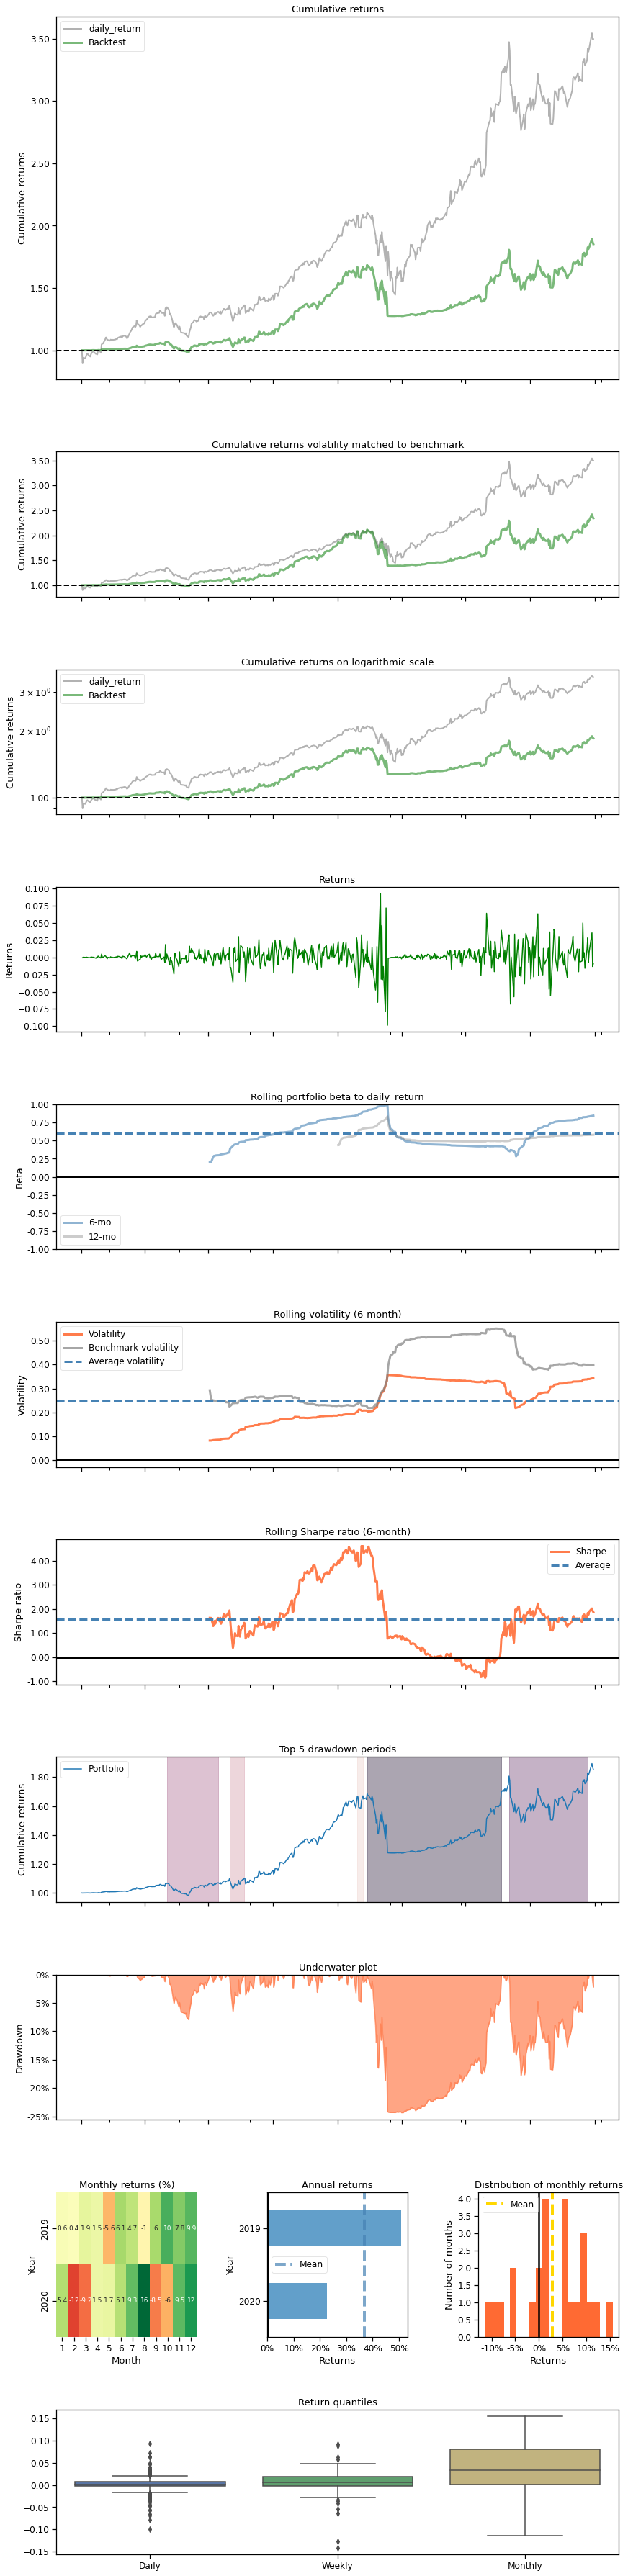

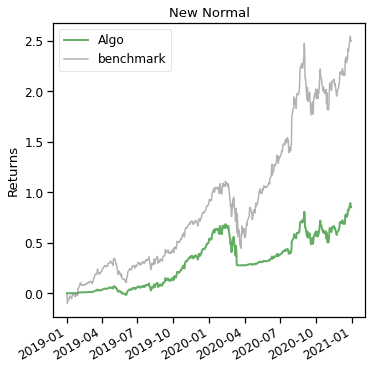

In [54]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = 'AAPL', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])